In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
from scipy.stats import entropy
import sys
sys.path.append('..')
sys.path.append('../odcd/cd/')
sys.path.append('../odcd/utils/')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
import matplotlib.pyplot as plt
import model_symmetries as vsf
%matplotlib inline

from skmultiflow.drift_detection.adwin import ADWIN

import streaming_sim_test as sst
from importlib import reload

import colorama
from colorama import Fore, Style

Using TensorFlow backend.


In [2]:
def prepare_data_cifar(cd='permute', perm_features=50, contam_cifar100=False):
    
    cifar = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar
    print('x_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
        
    if cd == 'new_classes':
        idxs_train_0_5 = np.where((y_train == 5) | (y_train == 4) | (y_train == 3) | 
                            (y_train == 2) | (y_train == 1) | (y_train == 0))
        idxs_test_0_5 = np.where((y_test == 5) | (y_test == 4) | (y_test == 3) | 
                            (y_test == 2) | (y_test == 1) | (y_test == 0))

        idxs_train_6_9 = np.where((y_train == 6) | (y_train == 7) | (y_train == 8) | 
                            (y_train == 9))
        idxs_test_6_9 = np.where((y_test == 6) | (y_test == 7) | (y_test == 8) | 
                            (y_test == 9))

        print(idxs_train_0_5[0].shape)
        print(idxs_test_0_5[0].shape)

        X_train_0_5 = X_train[idxs_train_0_5[0]]
        y_train_0_5 = y_train[idxs_train_0_5[0]]

        X_test_0_5 = X_test[idxs_test_0_5[0]]
        y_test_0_5 = y_test[idxs_test_0_5[0]]
    
        X_6_9 = X_test[idxs_test_6_9[0]]
        y_6_9 = y_test[idxs_test_6_9[0]]

        y_train_0_5 = tf.keras.utils.to_categorical(y_train_0_5)
        y_test_0_5 = tf.keras.utils.to_categorical(y_test_0_5)
        y_6_9 = tf.keras.utils.to_categorical(y_6_9)
    
        y_6_9 = np.delete(y_6_9, np.where(~y_6_9.any(axis=0)), axis=1)
        print(X_train_0_5.shape, y_train_0_5.shape)
        print(X_test_0_5.shape, y_test_0_5.shape)
        print(X_6_9.shape, y_6_9.shape)
        return X_train_0_5, y_train_0_5, X_test_0_5, y_test_0_5, X_6_9, y_6_9 
    
    elif cd == 'permute':
        mapp = {(32 * i) + j: [i, j]  for i in range(32) for j in range(32)}
        perm_1 = np.random.permutation(range(32 * 32))[:perm_features]
        perm_2 = np.random.permutation(range(32 * 32))[:perm_features]
        X_cd = X_test.copy()
        for t in zip(perm_1, perm_2):
            X_cd[:, mapp[t[0]][0], mapp[t[0]][1], :] = X_cd[:, mapp[t[1]][0], mapp[t[1]][1], :]
        y_cd = y_test
        
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
        y_cd = tf.keras.utils.to_categorical(y_cd)
        
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        print(X_cd.shape, y_cd.shape)
        return X_train, y_train, X_test, y_test, X_cd, y_cd
    
    elif cd == 'cifar100':
        cifar100 = tf.keras.datasets.cifar100.load_data()
        (X_train_100, y_train_100), (X_test_100, y_test_100) = cifar100
        
        X_cd, y_cd = X_test_100, y_test_100
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
        y_cd = tf.keras.utils.to_categorical(y_cd)
        
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        print(X_cd.shape, y_cd.shape)
        
        return X_train, y_train, X_test, y_test, X_cd, y_cd        

In [3]:
def model_cifar():
    x_in = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3),  activation='relu')(x_in)
    x = tf.keras.layers.Conv2D(32, (3, 3),  activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x_out = tf.keras.layers.Dense(10, activation='softmax')(x)
    
    cnn = tf.keras.models.Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
    
    return cnn

# Data prep

In [4]:
# cd = 'permute', 'new_classes' or 'cifar100'
X_train, y_train, X_test, y_test, X_cd, y_cd = prepare_data_cifar(cd='permute', perm_features=50)

x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)
(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)
(10000, 32, 32, 3) (10000, 10)


Sample instance from cifar X_test.


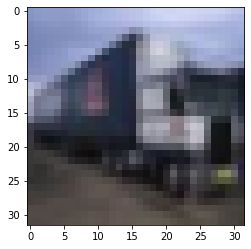

In [5]:
idx = 34
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from cifar X_test.')

Sample instance from cifar X_cd.


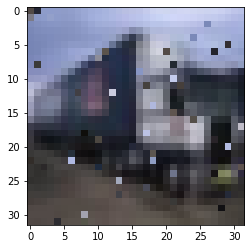

In [6]:
x = X_cd[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from cifar X_cd.')

# Train Model

In [7]:
clf = model_cifar()
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
__________

In [8]:
train = True
if train:
    clf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
else:
    clf = tf.keras.models.load_model('model_cifar.h5')

### Evaluate

In [9]:
print('Train')
sst.evaluate(clf, X_train, y_train)
print('Test')
sst.evaluate(clf, X_test, y_test)
print('cd')
sst.evaluate(clf, X_cd, y_cd)

Train
Accuracy: 0.84252
Confusion matrix: [[3995   12  131   21   29    8    7    8   64   40]
 [  24 4551    3    2    0    2    6    1   28   68]
 [ 155   16 3434  104   73   69   60   46   27   10]
 [ 103   22  226 3391  127  473  155  117   49   46]
 [ 143   17  445  268 4382  198  111  207   22   12]
 [  41   17  273  791   96 3995   93  164   22   12]
 [  42   21  331  266  133   82 4540   12   21   19]
 [  79   12  114  104  139  153    8 4426   14   33]
 [ 301   82   27   35   16    9   12   12 4717   65]
 [ 117  250   16   18    5   11    8    7   36 4695]]
Test
Accuracy: 0.7695
Confusion matrix: [[737  11  43   8   9   5   3   4  24  11]
 [ 11 830   0   3   1   0   0   1   9  28]
 [ 47   2 568  38  27  18  20  12   7   3]
 [ 28   8  53 544  37 122  49  25  15  14]
 [ 30   6 114  88 808  51  36  67   6   9]
 [ 13   5  81 192  26 730  18  53   5   4]
 [ 11  15  86  63  40  18 869   7   4   7]
 [ 18   3  33  37  44  48   2 823  10  14]
 [ 70  30  11  18   5   4   3   5 900  24]


# Symmetries

In [128]:
vae = vsf.VaeSymmetryFinderConv(clf, input_shape=(32, 32, 3), 
                                output_shape=(10, ), 
                                intermediate_dim=256, 
                                latent_dim=8, variational=False)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 64)   1792        encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 16, 16, 64)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 8, 8, 128)    73856       dropout_10[0][0]                 
__________________________________________________________________________________________________
dropou

In [129]:
vae.fit(X_train, x_test=X_test, epochs=30)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 11s 218us/step - loss: 1.1503 - val_loss: 0.7057
Epoch 2/30
50000/50000 [==============================] - 9s 188us/step - loss: 0.6236 - val_loss: 0.4868 1s - lo - ET
Epoch 3/30
50000/50000 [==============================] - 9s 188us/step - loss: 0.4244 - val_loss: 0.3961
Epoch 4/30
50000/50000 [==============================] - 10s 191us/step - loss: 0.3171 - val_loss: 0.3450
Epoch 5/30
50000/50000 [==============================] - 10s 190us/step - loss: 0.2427 - val_loss: 0.3150
Epoch 6/30
50000/50000 [==============================] - 10s 190us/step - loss: 0.1904 - val_loss: 0.3220
Epoch 7/30
50000/50000 [==============================] - 9s 190us/step - loss: 0.1570 - val_loss: 0.3066
Epoch 8/30
50000/50000 [==============================] - 10s 191us/step - loss: 0.1263 - val_loss: 0.2973
Epoch 9/30
50000/50000 [==============================] - 10s 192us/step - loss: 0.1

In [130]:
vae.save(arch_path='vae_arch_cifar.json', weights_path='vae_weights_cifar.h5')

In [131]:
vae_loaded = vsf.load_vae(arch_path='vae_arch_cifar.json', weights_path='vae_weights_cifar.h5')

Loaded model from disk


# Stream

In [132]:
# Symmetry signal
X_train_perm = np.random.permutation(X_train)
X_test_perm = np.random.permutation(X_test)
X_cd_perm = np.random.permutation(X_cd)

amp = 1
kl_train = vae_loaded.signal(X_train_perm, amp=amp)
kl_test = vae_loaded.signal(X_test_perm, amp=amp)
kl_cd = vae_loaded.signal(X_cd_perm, amp=amp)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_cd))
tr = len(kl_test)
tr

10000

In [133]:
tr = len(kl_test)
tr

10000

Sample instance from cifar X_test.


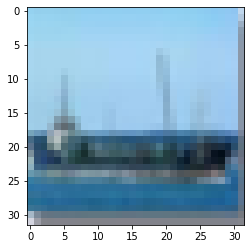

In [134]:
idx = 5000
x = X_train_perm[idx: idx+1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from cifar X_test.')

Sample instance from cifar X_test.


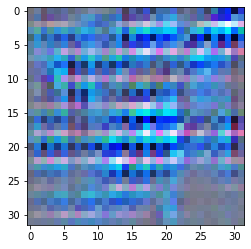

In [135]:
x_trans = vae_loaded.transform(x)
plt.imshow(np.squeeze(x_trans), 'gray')
print('Sample instance from cifar X_test.')

Sample instance from cifar X_test.


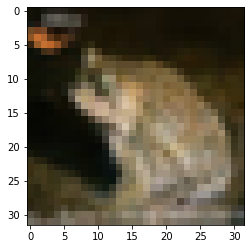

In [113]:
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from cifar X_test.')

In [114]:
vae_loaded.predict_original(x)

array([[2.3338056e-09, 2.2666320e-09, 3.4463551e-04, 2.6990364e-03,
        2.8882010e-04, 8.6017913e-05, 9.9658149e-01, 3.7405762e-08,
        2.3446848e-08, 4.5688120e-09]], dtype=float32)

In [115]:
vae_loaded.transform_predict(x)

array([[1.6236305e-05, 1.3942042e-05, 5.1059844e-03, 1.1070716e-02,
        5.0758566e-03, 1.9876240e-03, 9.7661465e-01, 7.7575140e-05,
        2.1391534e-05, 1.6003620e-05]], dtype=float32)

In [116]:
vae_loaded.signal(x)

array([0.01433514], dtype=float32)

In [117]:
kl_train[idx]

0.014347272

In [136]:
kl_train.mean()

0.032927033

In [137]:
kl_test.mean()

0.24052644

In [138]:
kl_cd.mean()

0.38774663

### Sudden drift

In [139]:
df = sst.make_data_stream(kl_concat, agg='mean')

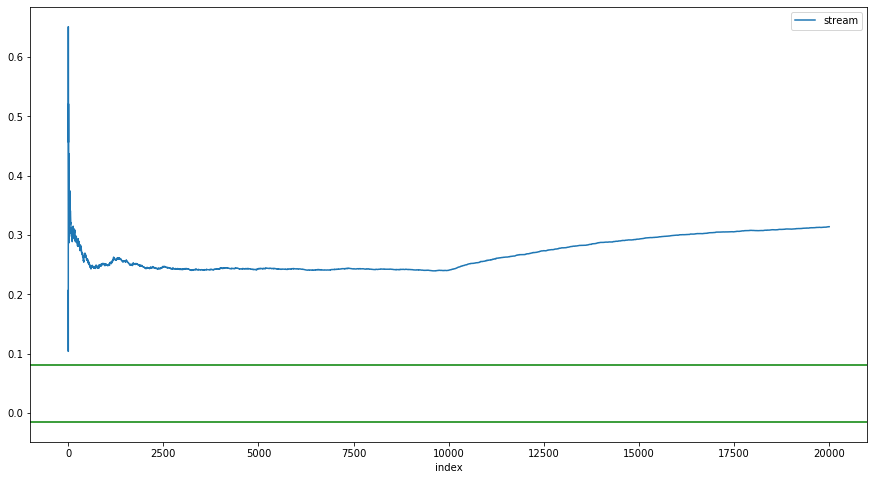

In [140]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus, c='g')
ax.axhline(baseline_std_minus, c='g')

In [141]:
adwin = ADWIN(delta=0.002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < tr:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

/home/Gigio/anaconda3/lib/python3.6/site-packages/skmultiflow/drift_detection/adwin.py:361: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


Change detected in data: 0.2486710425403004 - at index: 831
Change detected in data: 0.2774164863818661 - at index: 12895
Change detected in data: 0.305484141131204 - at index: 17471
Change detected in data: 0.30790569332219864 - at index: 17951
Change detected in data: 0.3109820561880273 - at index: 19199


### Gradual drift

In [58]:
reload(sst)

<module 'streaming_sim_test' from '../odcd/utils/streaming_sim_test.py'>

In [59]:
amp

1

In [60]:
cd_start = 2000
cd_full = int(2 * cd_start)
nb_samples_tot = 6000
start = 0
df = sst.rolling_stats(vae_loaded, X_test, y_test, X_cd, y_cd, cd_start, cd_full, nb_samples_tot, start, amp=amp)

Sample 0 of 6000
Sample 1000 of 6000
Sample 2000 of 6000
Sample 3000 of 6000
Sample 4000 of 6000
Sample 5000 of 6000


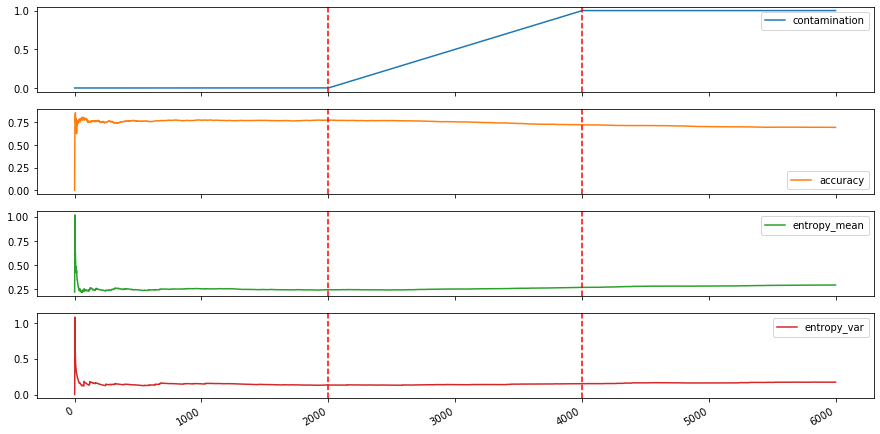

In [61]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

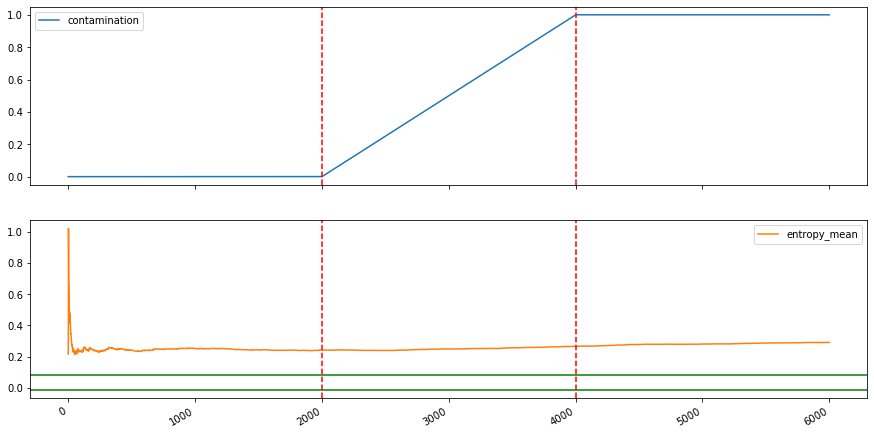

In [62]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus / amp, c='g')
axs[1].axhline(baseline_std_minus / amp, c='g')

In [63]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.00002)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.27883349333466767 - at index: 4703
Change detected in data: 0.2811338756209114 - at index: 5119
Change detected in data: 0.2880329061156285 - at index: 5631


/home/Gigio/anaconda3/lib/python3.6/site-packages/skmultiflow/drift_detection/adwin.py:361: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


---

# Old

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve
from importlib import reload
%matplotlib inline

Using TensorFlow backend.


In [2]:
sys.path.append('../odcd/cd/')
sys.path.append('../odcd/utils/')

In [3]:
import model_symmetries as vsf

In [4]:
import streaming_sim_test as sst

In [ ]:
def prepare_data_cifar(permute=False, perm_features=50, contam_cifar100=False):
    
    cifar = tf.keras.datasets.cifar10.load_data()
    (x_train, y_train), (x_test, y_test) = cifar
    print('x_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
        
    if not permute:
        idxs_train_0_5 = np.where((y_train == 5) | (y_train == 4) | (y_train == 3) | 
                            (y_train == 2) | (y_train == 1) | (y_train == 0))
        idxs_test_0_5 = np.where((y_test == 5) | (y_test == 4) | (y_test == 3) | 
                            (y_test == 2) | (y_test == 1) | (y_test == 0))

        idxs_train_6_9 = np.where((y_train == 6) | (y_train == 7) | (y_train == 8) | 
                            (y_train == 9))
        idxs_test_6_9 = np.where((y_test == 6) | (y_test == 7) | (y_test == 8) | 
                            (y_test == 9))

        print(idxs_train_0_5[0].shape)
        print(idxs_test_0_5[0].shape)

        X_train_0_5 = X_train[idxs_train_0_5[0]]
        y_train_0_5 = y_train[idxs_train_0_5[0]]

        X_test_0_5 = X_test[idxs_test_0_5[0]]
        y_test_0_5 = y_test[idxs_test_0_5[0]]
    
        X_6_9 = X_test[idxs_test_6_9[0]]
        y_6_9 = y_test[idxs_test_6_9[0]]

        y_train_0_5 = tf.keras.utils.to_categorical(y_train_0_5)
        y_test_0_5 = tf.keras.utils.to_categorical(y_test_0_5)
        y_6_9 = tf.keras.utils.to_categorical(y_6_9)
    
        y_6_9 = np.delete(y_6_9, np.where(~y_6_9.any(axis=0)), axis=1)
        print(X_train_0_5.shape, y_train_0_5.shape)
        print(X_test_0_5.shape, y_test_0_5.shape)
        print(X_6_9.shape, y_6_9.shape)
        return None, None, X_train_0_5, y_train_0_5, X_test_0_5, y_test_0_5, X_6_9, y_6_9 
    else:
        mapp = {(32 * i) + j: [i, j]  for i in range(32) for j in range(32)}
        perm_1 = np.random.permutation(range(32 * 32))[:perm_features]
        perm_2 = np.random.permutation(range(32 * 32))[:perm_features]
        X_cd = X_test.copy()
        for t in zip(perm_1, perm_2):
            X_cd[:, mapp[t[0]][0], mapp[t[0]][1], :] = X_cd[:, mapp[t[1]][0], mapp[t[1]][1], :]
        y_cd = y_test
        
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
        y_cd = tf.keras.utils.to_categorical(y_cd)
        
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        print(X_cd.shape, y_cd.shape)
        return None, None, X_train, y_train, X_test, y_test, X_cd, y_cd

# Load Cifar

In [5]:
cifar = tf.keras.datasets.cifar10.load_data()

In [6]:
(x_train, y_train), (x_test, y_test) = cifar
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [8]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [9]:
print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)


# Load model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

In [11]:
def model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

# Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
    return model

In [12]:
model_cifar = model()

In [13]:
model_cifar.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 141us/step - loss: 1.7627 - acc: 0.3625 - val_loss: 1.3449 - val_acc: 0.5183
Epoch 2/10
50000/50000 [==============================] - 4s 84us/step - loss: 1.3431 - acc: 0.5217 - val_loss: 1.1532 - val_acc: 0.5938
Epoch 3/10
50000/50000 [==============================] - 4s 81us/step - loss: 1.1205 - acc: 0.6043 - val_loss: 1.0149 - val_acc: 0.6402
Epoch 4/10
50000/50000 [==============================] - 4s 85us/step - loss: 0.9877 - acc: 0.6557 - val_loss: 0.9866 - val_acc: 0.6587
Epoch 5/10
50000/50000 [==============================] - 4s 85us/step - loss: 0.8910 - acc: 0.6881 - val_loss: 0.8384 - val_acc: 0.7087
Epoch 6/10
50000/50000 [==============================] - 4s 85us/step - loss: 0.8256 - acc: 0.7141 - val_loss: 0.8025 - val_acc: 0.7256
Epoch 7/10
50000/50000 [==============================] - 4s 81us/step - loss: 0.7642 - acc: 0.7346 - val_loss: 0.7226 - val_ac

In [14]:
model_cifar.save('model_cifar.h5')

# Find symmetries

In [118]:
reload(vsf)

<module 'model_symmetries' from '../odcd/cd/model_symmetries.py'>

In [119]:
#vae = vsf.VaeSymmetryFinder(model_cifar, input_shape=x_train.shape[1:], 
#                            output_shape=(10, ), intermediate_dim=256, output_activation='sigmoid', 
#                            latent_dim=16, opt='Adam')
vae = vsf.VaeSymmetryFinderConv(model_cifar, input_shape=x_train.shape[1:], 
                            output_shape=(10, ), intermediate_dim=128, output_activation='sigmoid', 
                            nb_conv_layers=2, latent_dim=16, opt='Adam')

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 16, 16, 64)   1792        encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_29 (Dropout)            (None, 16, 16, 64)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 8, 8, 128)    73856       dropout_29[0][0]                 
__________________________________________________________________________________________________
dropou

In [120]:
vae.fit(x_train, x_test=x_test, epochs=50)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 245us/step - loss: 1.7010 - val_loss: 1.2955
Epoch 2/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.1654 - val_loss: 0.8713
Epoch 3/50
50000/50000 [==============================] - 10s 205us/step - loss: 0.9542 - val_loss: 0.7071
Epoch 4/50
50000/50000 [==============================] - 10s 205us/step - loss: 0.8442 - val_loss: 0.6389
Epoch 5/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.7712 - val_loss: 0.5676
Epoch 6/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.7228 - val_loss: 0.4892
Epoch 7/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.6808 - val_loss: 0.4767
Epoch 8/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.6544 - val_loss: 0.4388
Epoch 9/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.6328 - val_

In [121]:
i = 1500
x = x_test[i:i+1]

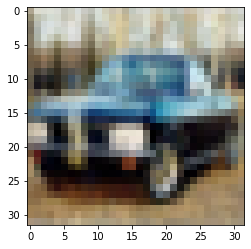

In [122]:
plt.imshow(np.squeeze(x))

In [123]:
model_pred = model_cifar.predict(x)
model_pred

array([[4.77075228e-05, 9.80321467e-01, 1.79587207e-08, 1.02519365e-07,
        6.89081006e-08, 4.13842933e-08, 8.86477096e-07, 8.88272496e-08,
        1.82710010e-05, 1.96113735e-02]], dtype=float32)

In [124]:
np.argmax(model_cifar.predict(x), axis=1)

array([1])

In [125]:
y_test[i:i+1]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [126]:
outs_1 = vae.vae.predict(x)
outs_2 = vae.vae.predict(x)

In [127]:
symmetric_sample_1 = outs_1[0]
symmetric_sample_2 = outs_2[0]

orig_pred_1 = outs_1[1]
orig_pred_2 = outs_2[1]

trans_pred_1 = outs_1[2]
trans_pred_2 = outs_2[2]

In [128]:
(model_pred == orig_pred_1).all()

True

In [129]:
trans_pred_1

array([[1.0291779e-03, 9.5313847e-01, 1.4559955e-04, 1.4520185e-04,
        8.6471073e-06, 1.8765480e-04, 1.6346671e-04, 5.1800482e-05,
        1.6067746e-03, 4.3523282e-02]], dtype=float32)

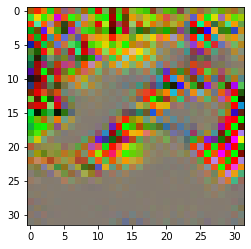

In [130]:
plt.imshow(np.squeeze(symmetric_sample_1))

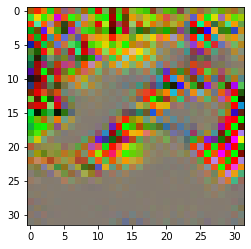

In [131]:
plt.imshow(np.squeeze(symmetric_sample_2))

# Streaming concept rift

In [132]:
cifar100 = tf.keras.datasets.cifar100.load_data()

In [133]:
(x_train_100, y_train_100), (x_test_100, y_test_100) = cifar100
print(x_train_100.shape, x_test_100.shape)
print(y_train_100.shape, y_test_100.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


In [134]:
x_train_100 = x_train_100.astype('float32')
x_test_100 = x_test_100.astype('float32')
x_train_100 /= 255
x_test_100 /= 255

In [135]:
accuracy_score(np.argmax(model_cifar.predict(x_test), axis=1), np.argmax(y_test, axis=1))

0.7695

In [136]:
accuracy_score(np.argmax(model_cifar.predict(x_test_100), axis=1), y_test_100)

0.0107

In [137]:
from scipy.stats import entropy

In [138]:
vae_outs_test = vae.vae.predict(x_test)
symm_samples_test = vae_outs_test[0]
orig_preds_test = vae_outs_test[1]
trans_preds_test = vae_outs_test[2]
    
kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
baseline_std_plus = kl_test.mean() + kl_test.std()
baseline_std_minus = kl_test.mean() - kl_test.std()

## Cifar 100 contamination

### Rolling one by one 

In [139]:
cd_start = 5000
cd_full = 2 * cd_start
nb_samples_tot = 15000
start = 100

In [140]:
reload(sst)

<module 'streaming_sim_test' from '../odcd/utils/streaming_sim_test.py'>

In [141]:
df = sst.rolling_stats(vae, x_test, y_test, x_test_100, y_test_100, cd_start, nb_samples_tot, start)

Sample 0 of 15000
Sample 1000 of 15000
Sample 2000 of 15000
Sample 3000 of 15000
Sample 4000 of 15000
Sample 5000 of 15000
Sample 6000 of 15000
Sample 7000 of 15000
Sample 8000 of 15000
Sample 9000 of 15000
Sample 10000 of 15000
Sample 11000 of 15000
Sample 12000 of 15000
Sample 13000 of 15000
Sample 14000 of 15000


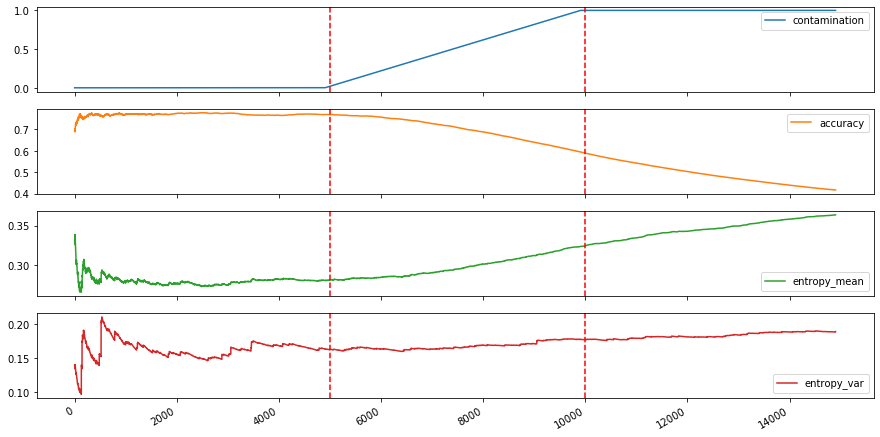

In [142]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

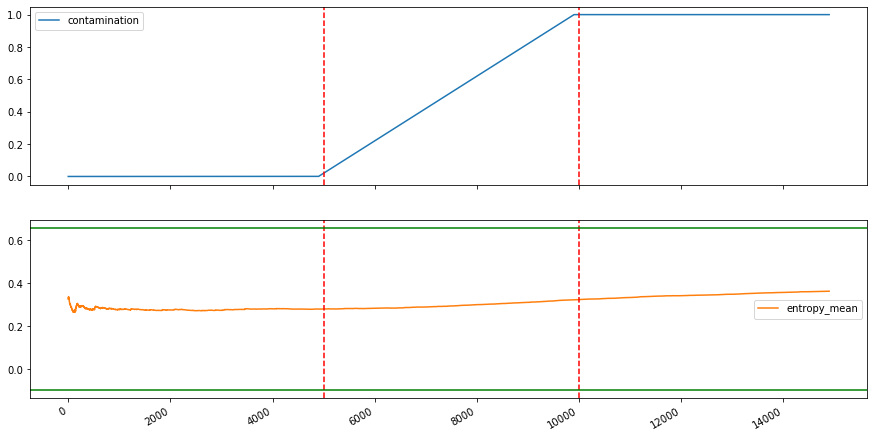

In [143]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

In [144]:
import seaborn as sns

In [72]:
reload(sns)

ImportError: cannot import name 'sort_df'

In [73]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="entropy", data=df.reset_index(), s=30, hue='rw')
ax.set(ylim=(-0.1, None))
plt.axvline(cd_start, c='r', linestyle='dashed')
plt.axvline(cd_full, c='r', linestyle='dashed')

AttributeError: module 'seaborn' has no attribute 'scatterplot'

<Figure size 1080x576 with 0 Axes>

### Rolling window

In [145]:
cd_start = 5000
nb_samples_tot = 15000
start = 0
window_size = 500

In [146]:
df, window_start, window_full = sst.sliding_window(vae, x_test, y_test, x_test_100, y_test_100, window_size, cd_start, nb_samples_tot, start)

Sample 0 of 15000
Sample 1000 of 15000
Sample 2000 of 15000
Sample 3000 of 15000
Sample 4000 of 15000
Sample 5000 of 15000
Sample 6000 of 15000
Sample 7000 of 15000
Sample 8000 of 15000
Sample 9000 of 15000
Sample 10000 of 15000
Sample 11000 of 15000
Sample 12000 of 15000
Sample 13000 of 15000
Sample 14000 of 15000


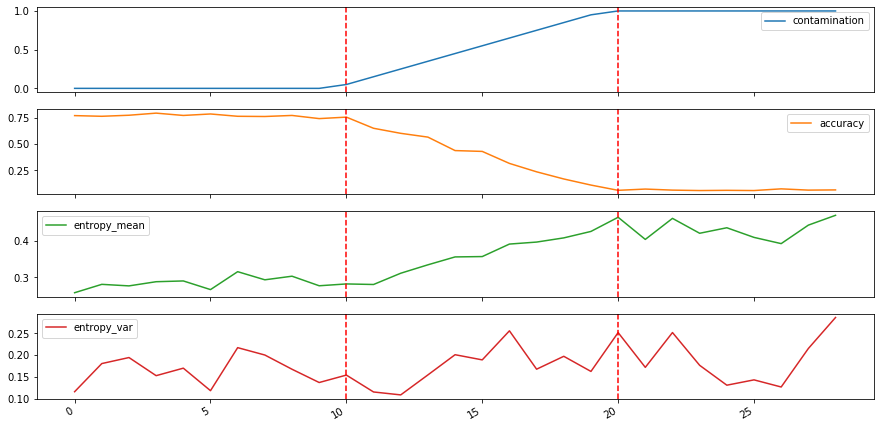

In [147]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(window_start, c='r', linestyle='dashed')
    ax.axvline(window_full, c='r', linestyle='dashed')

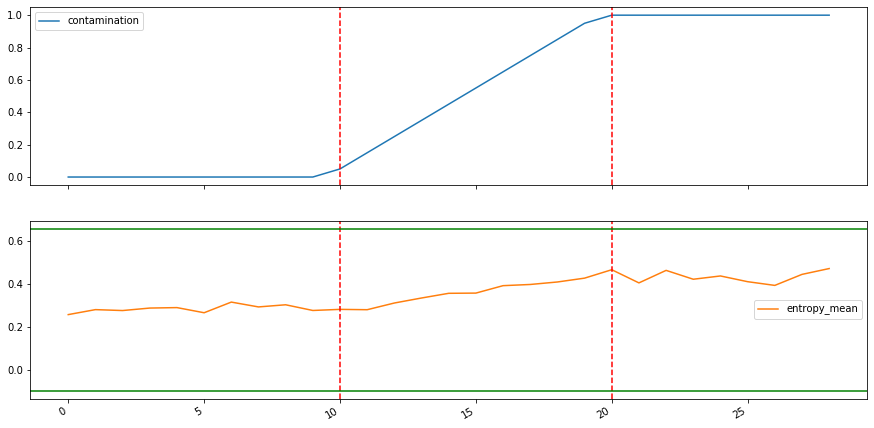

In [148]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(window_start, c='r', linestyle='dashed')
    ax.axvline(window_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

## Permutations

In [149]:
def permute(x_test, nb_perm):
    i = np.random.choice(range(32), nb_perm, replace=False)
    i_prime = np.random.choice(range(32), nb_perm, replace=False)
    j = np.random.choice(range(32), nb_perm, replace=False)
    j_prime = np.random.choice(range(32), nb_perm, replace=False)
    if nb_perm == 0:
        k = np.random.choice(range(3), 0, replace=False)
        k_prime = np.random.choice(range(3), 0, replace=False)
    else:
        k = np.random.choice(range(3), 1, replace=False)
        k_prime = np.random.choice(range(3), 1, replace=False)
    
    x_perm = x_test.copy()
    
    x_perm[:, i, :, :] = x_test[:, i_prime, :, :]
    x_perm[:, :, j, :] = x_test[:, :, j_prime, :]
    x_perm[:, :, :, k] = x_test[:, :, :, k_prime]
    return x_perm

In [150]:
X_perm = permute(x_test, 20)

### Rolling one by one 

In [151]:
cd_start = 5000
cd_full = 2 * cd_start
nb_samples_tot = 15000
start = 100

In [152]:
reload(sst)

<module 'streaming_sim_test' from '../odcd/utils/streaming_sim_test.py'>

In [153]:
df = sst.rolling_stats(vae, x_test, y_test, X_perm, y_test, cd_start, nb_samples_tot, start)

Sample 0 of 15000
Sample 1000 of 15000
Sample 2000 of 15000
Sample 3000 of 15000
Sample 4000 of 15000
Sample 5000 of 15000
Sample 6000 of 15000
Sample 7000 of 15000
Sample 8000 of 15000
Sample 9000 of 15000
Sample 10000 of 15000
Sample 11000 of 15000
Sample 12000 of 15000
Sample 13000 of 15000
Sample 14000 of 15000


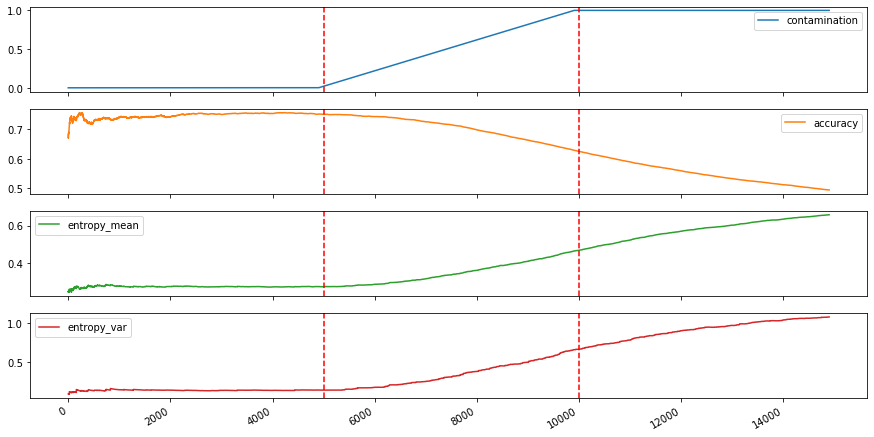

In [154]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

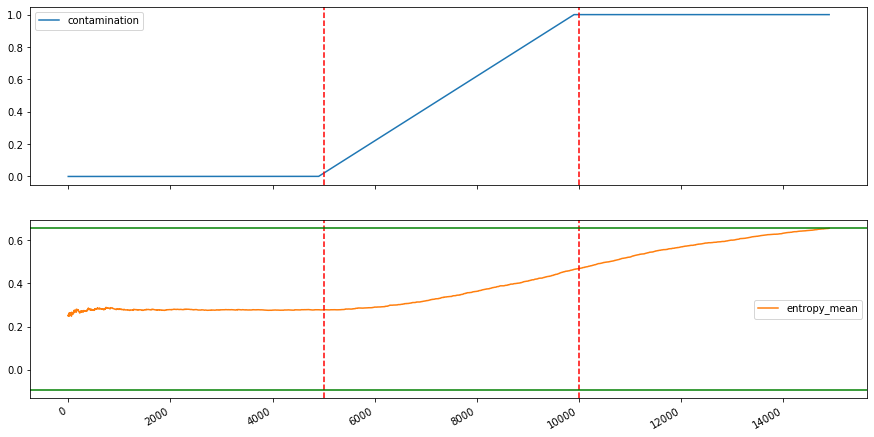

In [155]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

In [71]:
import seaborn as sns

In [72]:
reload(sns)

ImportError: cannot import name 'sort_df'

In [73]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="entropy", data=df.reset_index(), s=30, hue='rw')
ax.set(ylim=(-0.1, None))
plt.axvline(cd_start, c='r', linestyle='dashed')
plt.axvline(cd_full, c='r', linestyle='dashed')

AttributeError: module 'seaborn' has no attribute 'scatterplot'

<Figure size 1080x576 with 0 Axes>

### Rolling window

In [156]:
cd_start = 5000
nb_samples_tot = 15000
start = 0
window_size = 500

In [157]:
df, window_start, window_full = sst.sliding_window(vae, x_test, y_test, X_perm, y_test, window_size, cd_start, nb_samples_tot, start)

Sample 0 of 15000
Sample 1000 of 15000
Sample 2000 of 15000
Sample 3000 of 15000
Sample 4000 of 15000
Sample 5000 of 15000
Sample 6000 of 15000
Sample 7000 of 15000
Sample 8000 of 15000
Sample 9000 of 15000
Sample 10000 of 15000
Sample 11000 of 15000
Sample 12000 of 15000
Sample 13000 of 15000
Sample 14000 of 15000


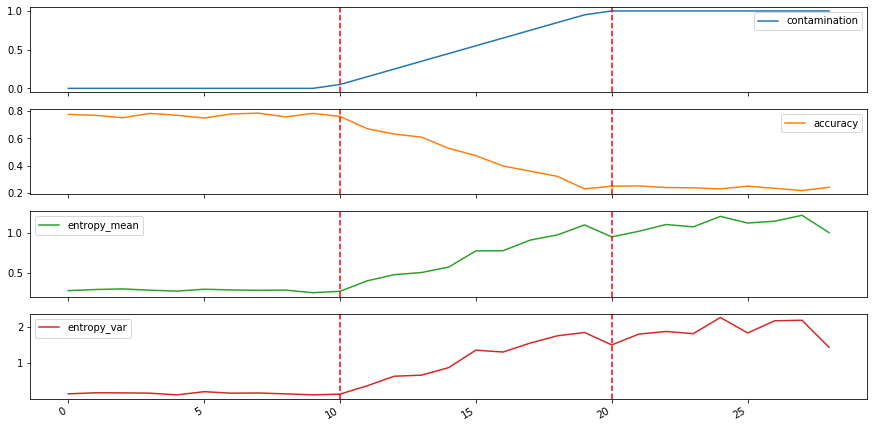

In [158]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(window_start, c='r', linestyle='dashed')
    ax.axvline(window_full, c='r', linestyle='dashed')

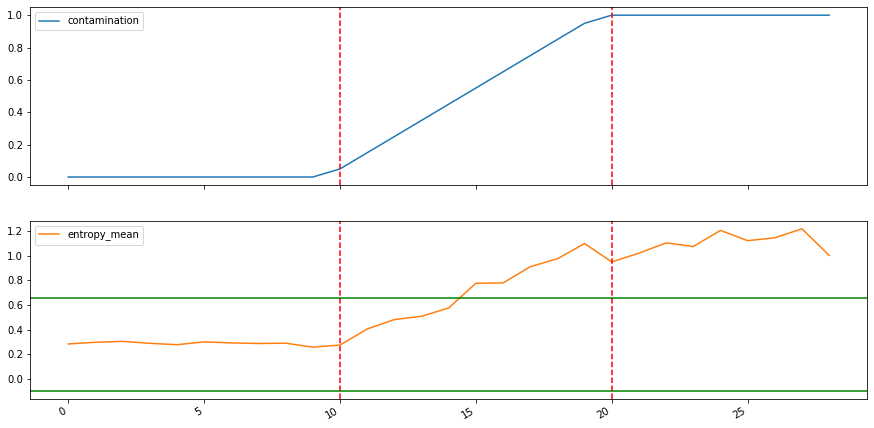

In [159]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(window_start, c='r', linestyle='dashed')
    ax.axvline(window_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

# Test concept dirft

In [ ]:
from scipy.ndimage import rotate
import pandas as pd
from scipy.stats import entropy

In [ ]:
window = 100

In [ ]:
def permute(x_test, nb_perm):
    i = np.random.choice(range(32), nb_perm, replace=False)
    i_prime = np.random.choice(range(32), nb_perm, replace=False)
    j = np.random.choice(range(32), nb_perm, replace=False)
    j_prime = np.random.choice(range(32), nb_perm, replace=False)
    if nb_perm == 0:
        k = np.random.choice(range(3), 0, replace=False)
        k_prime = np.random.choice(range(3), 0, replace=False)
    else:
        k = np.random.choice(range(3), 1, replace=False)
        k_prime = np.random.choice(range(3), 1, replace=False)
    
    x_perm = x_test.copy()
    
    x_perm[:, i, :, :] = x_test[:, i_prime, :, :]
    x_perm[:, :, j, :] = x_test[:, :, j_prime, :]
    x_perm[:, :, :, k] = x_test[:, :, :, k_prime]
    return x_perm

In [ ]:
def sample_window(X_test, y_test, window):
    samples_rnd = np.random.choice(range(len(X_test)), window, replace=False)
    X_test_samples = X_test[samples_rnd, :]
    y_test_samples = y_test[samples_rnd]
    return X_test_samples, y_test_samples

In [ ]:
cifar100 = tf.keras.datasets.cifar100.load_data()

In [ ]:
(x_train_100, y_train_100), (x_test_100, y_test_100) = cifar100
print(x_train_100.shape, x_test_100.shape)
print(y_train_100.shape, y_test_100.shape)

In [ ]:
x_train_100 = x_train_100.astype('float32')
x_test_100 = x_test_100.astype('float32')
x_train_100 /= 255
x_test_100 /= 255

In [ ]:
accuracy_score(np.argmax(model_cifar.predict(x_test), axis=1), np.argmax(y_test, axis=1))

In [ ]:
accuracy_score(np.argmax(model_cifar.predict(x_test_100), axis=1), y_test_100)

In [ ]:
vae_outs_test = vae.vae.predict(x_test)
symm_samples_test = vae_outs_test[0]
orig_preds_test = vae_outs_test[1]
trans_preds_test = vae_outs_test[2]
    
kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
baseline_std_plus = kl_test.mean() + kl_test.std()
baseline_std_minus = kl_test.mean() - kl_test.std()

### contamination cifar100

In [125]:
y_test = np.argmax(y_test, axis=1)

In [126]:
y_test_100 = y_test_100.flatten()

In [127]:
x_test_100.shape

(10000, 32, 32, 3)

In [154]:
mean_test = []
std_test = []
accs_test = []
baseline_stds_plus = []
baseline_stds_minus = []
for step in range(100):
    if step < 99:
        x_window, y_window = sample_window(x_test, y_test, window)
        vae_outs_test = vae.vae.predict(x_window.reshape(x_window.shape[0], 32, 32, 3))
        symm_samples_test = vae_outs_test[0]
        orig_preds_test = vae_outs_test[1]
        trans_preds_test = vae_outs_test[2]
    
        kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
        mean_test.append(kl_test.mean())
        std_test.append(kl_test.std())
        preds_test = np.argmax(orig_preds_test, axis=1)
        accs_test.append(accuracy_score(preds_test, y_window))
    
        baseline_stds_plus.append(baseline_std_plus)
        baseline_stds_minus.append(baseline_std_minus)
    else:
        for i in range(0, len(x_test_100), 500):
            x_window, y_window = sample_window(x_test, y_test, window)
            rnd_idxs  = np.random.choice(range(len(x_test_100)), i)
    
            x_cont = x_test_100[rnd_idxs]
            y_cont = y_test_100[rnd_idxs]
    
            #print(len(rnd_idxs), y_test.shape, y_cont.shape)
            print('Number of contaminations: {} '.format(i))
            x_test_cont = np.concatenate((x_window, x_cont), axis=0)
            y_test_cont = np.concatenate((y_window, y_cont), axis=0)
            vae_outs_test = vae.vae.predict(x_test_cont.reshape(x_test_cont.shape[0], 32, 32, 3))
            symm_samples_test = vae_outs_test[0]
            orig_preds_test = vae_outs_test[1]
            trans_preds_test = vae_outs_test[2]
    
            kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
            mean_test.append(kl_test.mean())
            std_test.append(kl_test.std())
            preds_test = np.argmax(orig_preds_test, axis=1)
            accs_test.append(accuracy_score(preds_test, y_test_cont))
    
            baseline_stds_plus.append(baseline_std_plus)
            baseline_stds_minus.append(baseline_std_minus)

Number of contaminations: 0 
Number of contaminations: 500 
Number of contaminations: 1000 
Number of contaminations: 1500 
Number of contaminations: 2000 
Number of contaminations: 2500 
Number of contaminations: 3000 
Number of contaminations: 3500 
Number of contaminations: 4000 
Number of contaminations: 4500 
Number of contaminations: 5000 
Number of contaminations: 5500 
Number of contaminations: 6000 
Number of contaminations: 6500 
Number of contaminations: 7000 
Number of contaminations: 7500 
Number of contaminations: 8000 
Number of contaminations: 8500 
Number of contaminations: 9000 
Number of contaminations: 9500 


In [155]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test
df['baseline_std_plus'] = baseline_stds_plus
df['baseline_std_minus'] = baseline_stds_minus

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe550889a20>,
      dtype=object)

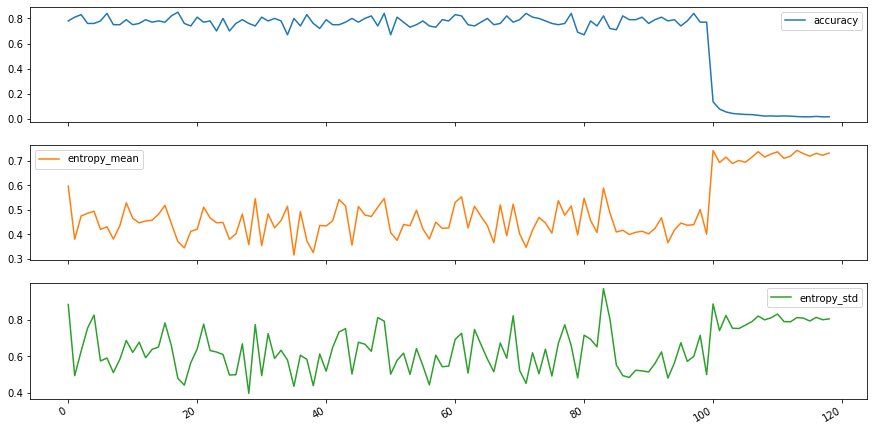

In [156]:
df[['accuracy','entropy_mean','entropy_std']].plot(logy = False, subplots=True, figsize = (15, 8))

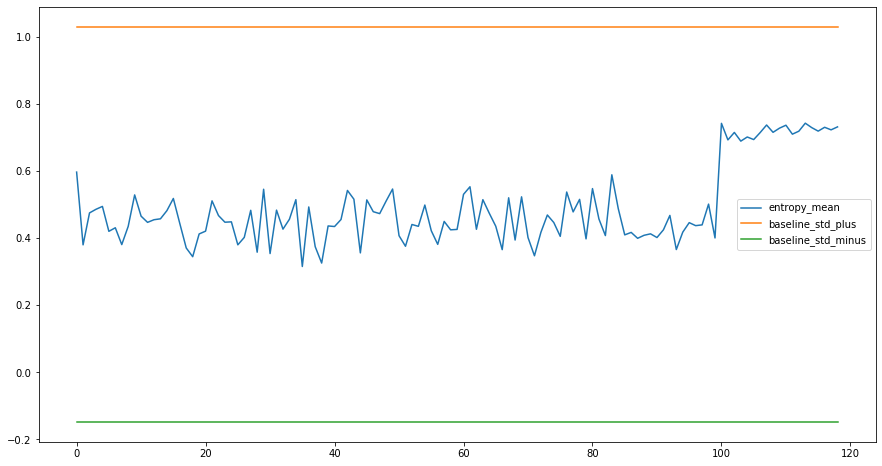

In [157]:
df[['entropy_mean', 'baseline_std_plus', 'baseline_std_minus']].plot(logy = False, subplots=False, figsize = (15, 8))

### Rotations

In [158]:
mean_test = []
std_test = []
accs_test = []
baseline_stds_plus = []
baseline_stds_minus = []
for step in range(100):
    if step < 99:
        x_window, y_window = sample_window(x_test, y_test, window)
        vae_outs_test = vae.vae.predict(x_window.reshape(x_window.shape[0], 32, 32, 3))
        symm_samples_test = vae_outs_test[0]
        orig_preds_test = vae_outs_test[1]
        trans_preds_test = vae_outs_test[2]
    
        kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
        mean_test.append(kl_test.mean())
        std_test.append(kl_test.std())
        preds_test = np.argmax(orig_preds_test, axis=1)
        accs_test.append(accuracy_score(preds_test, y_window))
    
        baseline_stds_plus.append(baseline_std_plus)
        baseline_stds_minus.append(baseline_std_minus)
    else:
        for i in range(45):
            x_window, y_window = sample_window(x_test, y_test, window)
            print('Rotating images by {} degree'.format(i))
            x_test_rot = rotate(x_window, i, axes=(1, 2), reshape=False)
    
            vae_outs_test = vae.vae.predict(x_test_rot.reshape(x_test_rot.shape[0], 32, 32, 3))
            symm_samples_test = vae_outs_test[0]
            orig_preds_test = vae_outs_test[1]
            trans_preds_test = vae_outs_test[2]
    
            kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
            mean_test.append(kl_test.mean())
            std_test.append(kl_test.std())
            preds_test = np.argmax(orig_preds_test, axis=1)
            accs_test.append(accuracy_score(preds_test, y_window))
    
            baseline_stds_plus.append(baseline_std_plus)
            baseline_stds_minus.append(baseline_std_minus)

Rotating images by 0 degree
Rotating images by 1 degree
Rotating images by 2 degree
Rotating images by 3 degree
Rotating images by 4 degree
Rotating images by 5 degree
Rotating images by 6 degree
Rotating images by 7 degree
Rotating images by 8 degree
Rotating images by 9 degree
Rotating images by 10 degree
Rotating images by 11 degree
Rotating images by 12 degree
Rotating images by 13 degree
Rotating images by 14 degree
Rotating images by 15 degree
Rotating images by 16 degree
Rotating images by 17 degree
Rotating images by 18 degree
Rotating images by 19 degree
Rotating images by 20 degree
Rotating images by 21 degree
Rotating images by 22 degree
Rotating images by 23 degree
Rotating images by 24 degree
Rotating images by 25 degree
Rotating images by 26 degree
Rotating images by 27 degree
Rotating images by 28 degree
Rotating images by 29 degree
Rotating images by 30 degree
Rotating images by 31 degree
Rotating images by 32 degree
Rotating images by 33 degree
Rotating images by 34 de

In [159]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test
df['baseline_std_plus'] = baseline_stds_plus
df['baseline_std_minus'] = baseline_stds_minus

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5496ab860>,
      dtype=object)

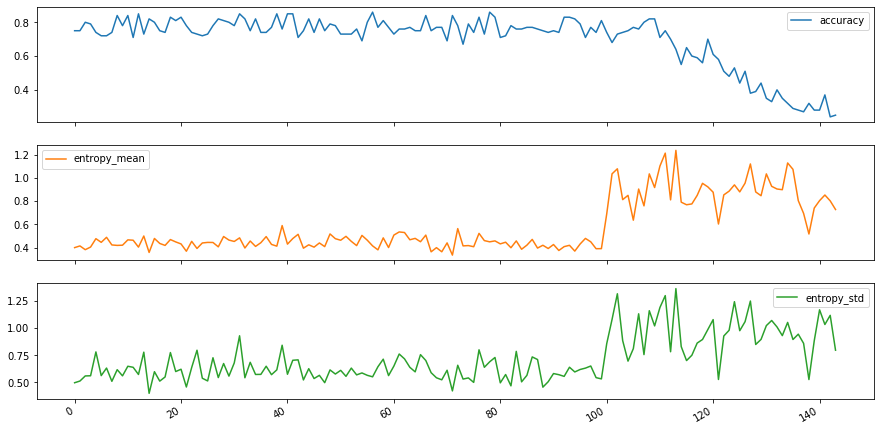

In [160]:
df[['accuracy','entropy_mean','entropy_std']].plot(logy = False, subplots=True, figsize = (15, 8))

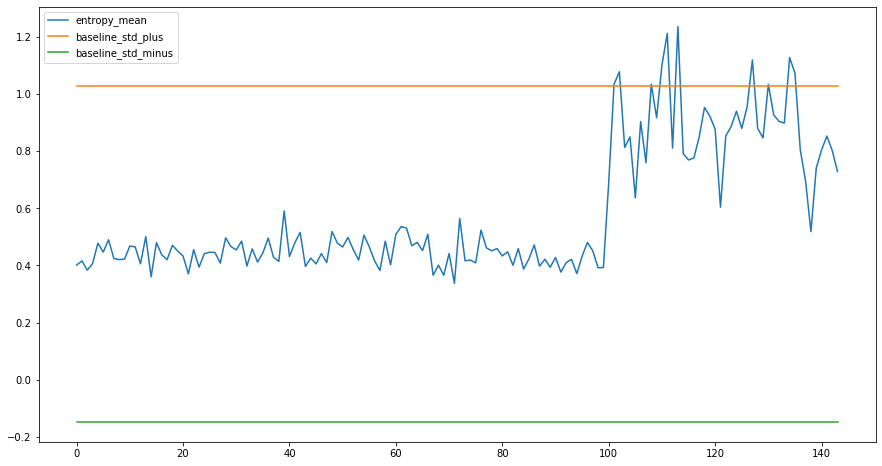

In [161]:
df[['entropy_mean', 'baseline_std_plus', 'baseline_std_minus']].plot(logy = False, subplots=False, figsize = (15, 8))

### Stream simulation features permutation

In [162]:
mean_test = []
std_test = []
accs_test = []
baseline_stds_plus = []
baseline_stds_minus = []

for step in range(100):
    if step < 99:
        x_window, y_window = sample_window(x_test, y_test, window)
        vae_outs_test = vae.vae.predict(x_window.reshape(x_window.shape[0], 32, 32, 3))
        symm_samples_test = vae_outs_test[0]
        orig_preds_test = vae_outs_test[1]
        trans_preds_test = vae_outs_test[2]
    
        kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
        mean_test.append(kl_test.mean())
        std_test.append(kl_test.std())
        preds_test = np.argmax(orig_preds_test, axis=1)
        accs_test.append(accuracy_score(preds_test, y_window))
    
        baseline_stds_plus.append(baseline_std_plus)
        baseline_stds_minus.append(baseline_std_minus)
    else:
        for nb_perm in range(32):
            x_window, y_window = sample_window(x_test, y_test, window)
            x_perm = permute(x_window, nb_perm)
    
            print('Nb of permutations: {}'.format(nb_perm))
            vae_outs_test = vae.vae.predict(x_perm.reshape(x_perm.shape[0], 32, 32, 3))
            symm_samples_test = vae_outs_test[0]
            orig_preds_test = vae_outs_test[1]
            trans_preds_test = vae_outs_test[2]
    
            kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
            mean_test.append(kl_test.mean())
            std_test.append(kl_test.std())
            preds_test = np.argmax(orig_preds_test, axis=1)
            accs_test.append(accuracy_score(preds_test, y_window))
    
            baseline_stds_plus.append(baseline_std_plus)
            baseline_stds_minus.append(baseline_std_minus)

Nb of permutations: 0
Nb of permutations: 1
Nb of permutations: 2
Nb of permutations: 3
Nb of permutations: 4
Nb of permutations: 5
Nb of permutations: 6
Nb of permutations: 7
Nb of permutations: 8
Nb of permutations: 9
Nb of permutations: 10
Nb of permutations: 11
Nb of permutations: 12
Nb of permutations: 13
Nb of permutations: 14
Nb of permutations: 15
Nb of permutations: 16
Nb of permutations: 17
Nb of permutations: 18
Nb of permutations: 19
Nb of permutations: 20
Nb of permutations: 21
Nb of permutations: 22
Nb of permutations: 23
Nb of permutations: 24
Nb of permutations: 25
Nb of permutations: 26
Nb of permutations: 27
Nb of permutations: 28
Nb of permutations: 29
Nb of permutations: 30
Nb of permutations: 31


In [163]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test
df['baseline_std_plus'] = baseline_stds_plus
df['baseline_std_minus'] = baseline_stds_minus

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5506c0ba8>,
      dtype=object)

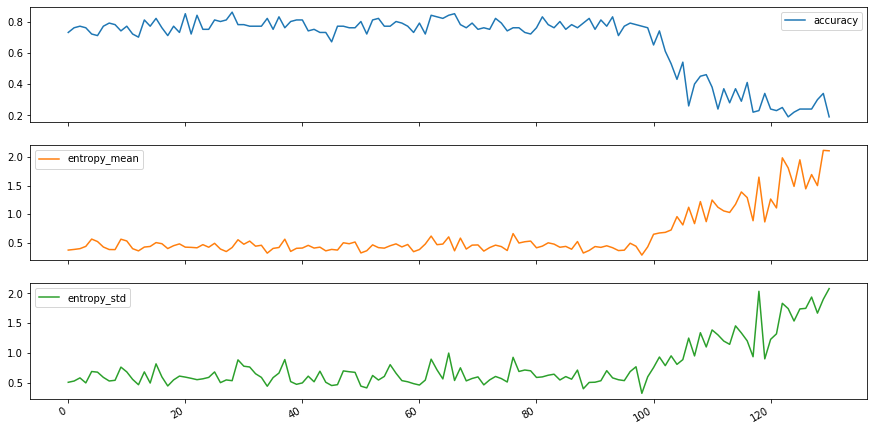

In [164]:
df[['accuracy','entropy_mean','entropy_std']].plot(logy = False, subplots=True, figsize = (15, 8))

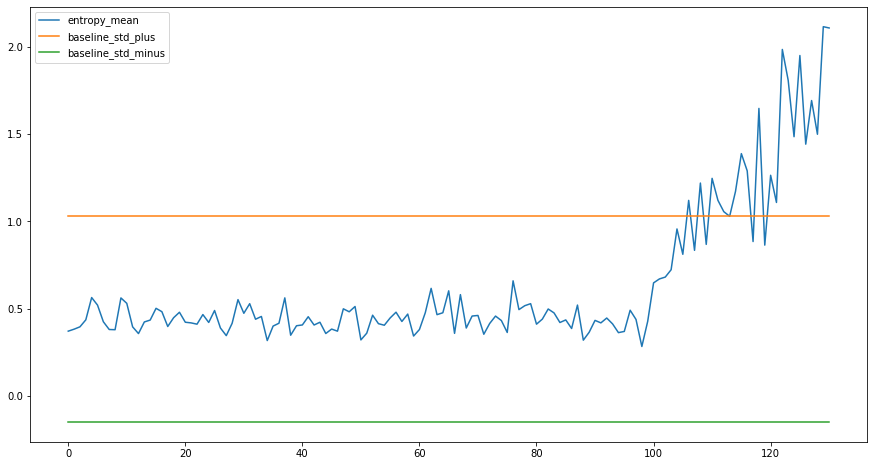

In [165]:
df[['entropy_mean', 'baseline_std_plus', 'baseline_std_minus']].plot(logy = False, subplots=False, figsize = (15, 8))

# Streaming

In [ ]:
cd_start = 5000
cd_full = 2 * cd_start
nb_samples_tot = 15000
start = 100

In [ ]:
df = vsf.rolling_stats(vae, X_test, y_test, X_red, y_red, cd_start, nb_samples_tot, start)

# ACDC

### random features permutation

In [93]:
x_test.shape

(10000, 32, 32, 3)

In [94]:
nb_features = 32 * 32 

In [95]:
nb_features

1024

In [96]:
mean_test = []
std_test = []
accs_test = []
baseline_stds_plus = []
baseline_stds_minus = []
for nb_perm in range(20):
    i = np.random.choice(range(32), nb_perm)
    i_prime = np.random.choice(range(32), nb_perm)
    j = np.random.choice(range(32), nb_perm)
    j_prime = np.random.choice(range(32), nb_perm)
    if nb_perm == 0:
        k = np.random.choice(range(3), 0)
        k_prime = np.random.choice(range(3), 0)
    else:
        k = np.random.choice(range(3), 1)
        k_prime = np.random.choice(range(3), 1)
    
    x_perm = x_test.copy()
    
    x_perm[:, i, :, :] = x_test[:, i_prime, :, :]
    x_perm[:, :, j, :] = x_test[:, :, j_prime, :]
    x_perm[:, :, :, k] = x_test[:, :, :, k_prime]
    
    print('Nb of permutations: {}'.format(nb_perm))
    vae_outs_test = vae.vae.predict(x_perm.reshape(x_perm.shape[0], 32, 32, 3))
    symm_samples_test = vae_outs_test[0]
    orig_preds_test = vae_outs_test[1]
    trans_preds_test = vae_outs_test[2]
    
    kl_test = entropy(orig_preds_test.T, trans_preds_test.T)
    mean_test.append(kl_test.mean())
    std_test.append(kl_test.std())
    preds_test = np.argmax(orig_preds_test, axis=1)
    accs_test.append(accuracy_score(preds_test, y_test))
    
    baseline_stds_plus.append(baseline_std_plus)
    baseline_stds_minus.append(baseline_std_minus)

Nb of permutations: 0
Nb of permutations: 1
Nb of permutations: 2
Nb of permutations: 3
Nb of permutations: 4
Nb of permutations: 5
Nb of permutations: 6
Nb of permutations: 7
Nb of permutations: 8
Nb of permutations: 9
Nb of permutations: 10
Nb of permutations: 11
Nb of permutations: 12
Nb of permutations: 13
Nb of permutations: 14
Nb of permutations: 15
Nb of permutations: 16
Nb of permutations: 17
Nb of permutations: 18
Nb of permutations: 19


In [97]:
df = pd.DataFrame()
df['accuracy'] = accs_test
df['entropy_mean'] = mean_test
df['entropy_std'] = std_test
df['baseline_std_plus'] = baseline_stds_plus
df['baseline_std_minus'] = baseline_stds_minus

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f789b3705f8>,
      dtype=object)

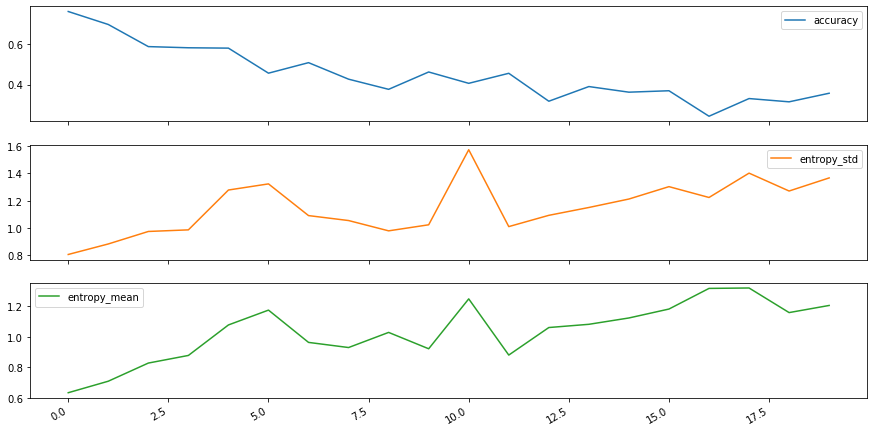

In [98]:
df[['accuracy','entropy_std','entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))

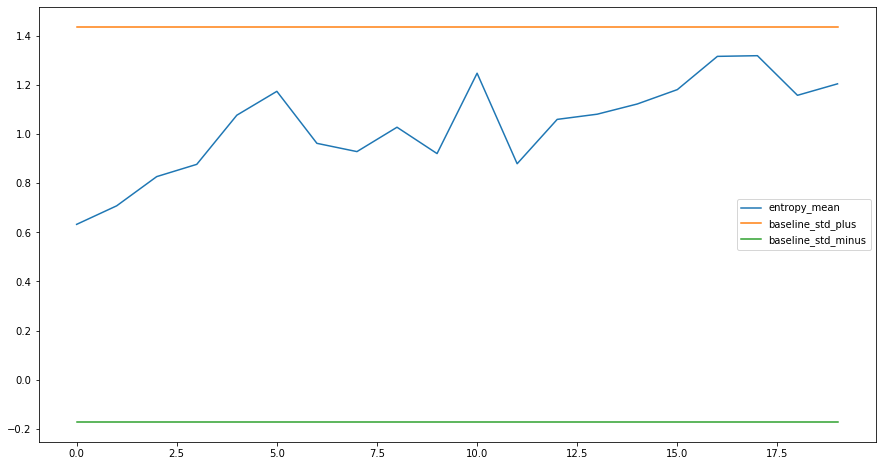

In [99]:
df[['entropy_mean', 'baseline_std_plus', 'baseline_std_minus']].plot(logy = False, subplots=False, figsize = (15, 8))

In [273]:
n

1987

In [301]:
i = np.random.choice(range(32), 0)
i_prime = np.random.choice(range(32), 0)
j = np.random.choice(range(32), 0)
j_prime = np.random.choice(range(32), 0)
k = np.random.choice(range(3), 0)
k_prime = np.random.choice(range(3), 0)

In [302]:
x_perm = x_test.copy()

In [303]:
(x_test == x_perm).all()

True

In [304]:
x_perm[:, i, :, :] = x_test[:, i_prime, :, :]
x_perm[:, :, j, :] = x_test[:, :, j_prime, :]
x_perm[:, :, :, k] = x_test[:, :, :, k_prime]

In [305]:
(x_test == x_perm).all()

True

In [290]:
j

array([ 5,  8,  8, 15, 13])

In [291]:
k

array([0])

In [295]:
x_test[:, i, :, :].shape

(10000, 5, 32, 3)

In [281]:
k = 32 % (32 * 32)

In [282]:
k

32

In [277]:
j = (2009 - (k * 32 * 32)) % 32

In [278]:
j

25

In [ ]:
i = (32 * 32) 